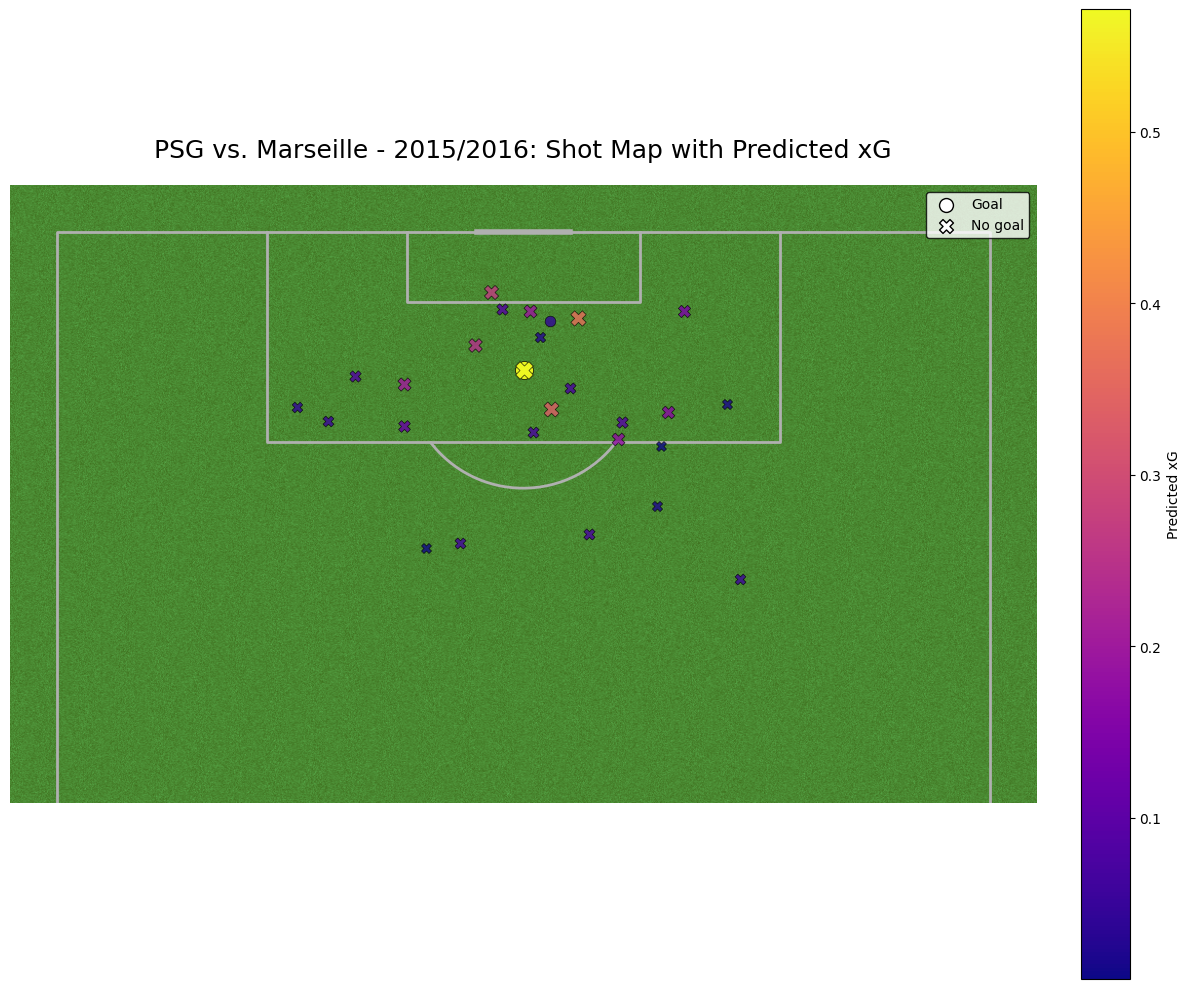

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
import pickle

# Load the trained xG model
with open("models/xgboost.pkl", "rb") as f:
    model = pickle.load(f)

# Read in the enriched shots data for PSG vs. Marseille
df = pd.read_csv("data/psg_marseille_shots_enriched.csv")

# Define the input features and target
features = [
    "x", "y",
    "shot_body_part", "shot_technique",
    "under_pressure", "shot_first_time",
    "distance_to_goal", "angle_to_goal",
    "is_central_zone", "is_left_side", "is_right_side"
]
target = "goal"

X = df[features]

# Compute predicted xG for each shot
df['y_proba'] = model.predict_proba(X)[:, 1]

# Create a half-pitch for shot plotting
pitch = VerticalPitch(
    pitch_type='statsbomb',
    pitch_color='grass',
    half=True,
    pad_bottom=-11
)
fig, ax = pitch.draw(figsize=(12, 10))

# Prepare colormap normalization
norm = plt.Normalize(df['y_proba'].min(), df['y_proba'].max())
cmap = plt.cm.plasma

# Plot each shot: circle for goals, cross for non-goals,
# color intensity and size based on predicted xG
for _, shot in df.iterrows():
    shot_color = cmap(norm(shot['y_proba']))
    marker = 'o' if shot['goal'] == 1 else 'X'
    marker_size = 200 * shot['y_proba'] + 50
    pitch.scatter(
        shot['x'], shot['y'],
        ax=ax,
        s=marker_size,
        marker=marker,
        color=shot_color,
        edgecolors='black',
        linewidth=0.5,
        alpha=0.8
    )

# Add a colorbar to interpret xG values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Predicted xG')

# Manually add legend entries for goals vs. non-goals
ax.scatter([], [], c='white', edgecolors='black', marker='o', s=100, label='Goal')
ax.scatter([], [], c='white', edgecolors='black', marker='X', s=100, label='No goal')
ax.legend(
    loc='upper right',
    facecolor='white',
    framealpha=0.8,
    edgecolor='black'
)

# Set a clear, descriptive title
ax.set_title("PSG vs. Marseille - 2015/2016: Shot Map with Predicted xG", fontsize=18, pad=20)

plt.show()
